In [0]:
!pip install -q 'gwpy==1.0.1'

     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 2.7MB 17.3MB/s 


In [0]:
import sys
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir

     |████████████████████████████████| 3.2MB 2.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 29.0MB 1.3MB/s 
     |████████████████████████████████| 81kB 50.9MB/s 
     |████████████████████████████████| 1.6MB 49.2MB/s 
     |████████████████████████████████| 798kB 46.3MB/s 
  Created wheel for pycbc: filename=PyCBC-1.16.1-cp36-cp36m-linux_x86_64.whl size=5636903 sha256=4a5dfc78503fb7a5a10ef06235bc57a97fc8c71a237fc2298af470f1ffddf24c
  Stored in directory: /tmp/pip-ephem-wheel-cache-cb7o1o_r/wheels/73/03/a1/e933f9ab69b7baf08f483e2fc15004fafe099c2e47c3c7f205
Successfully built pycbc
  Created wheel for emcee: filename=emcee-2.2.1-cp36-none-any.whl size=29597 sha256=76ea475e17f6eb01b95825914a236875c99e9c6dfe0a866a6b4e7d3817d93040
  Stored in directory: /tmp/pip-ephem-wheel-cache-cb7o1o_r/wheels/2f/5d/a5/78f84e23329ad7d9b1787c9d24371100cae74cdefe25eba50d
  Create

In [0]:
!pip install gwpy lalsuite

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


KeyboardInterrupt: ignored

In [0]:
!ls "/content/gdrive/My Drive/challenge3.gwf"

'/content/gdrive/My Drive/challenge3.gwf'


In [0]:
!pip install PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':"1681WuONd9kH1x0TucOEW-zCiVb18DeSH"})   # replace the id with id of file you want to access
downloaded.GetContentFile('challenge3.gwf')    

In [0]:
from gwpy.timeseries import TimeSeries
data = TimeSeries.read('challenge3.gwf', 'H1:CHALLENGE3')

In [0]:
import numpy as np
signal=np.array(data)

In [0]:
import matplotlib.pyplot as plt


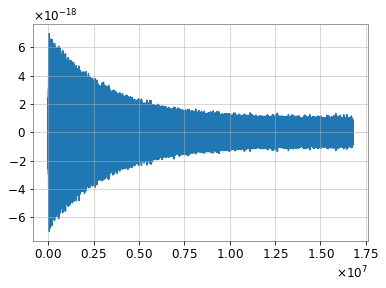

In [0]:
plt.plot(signal)

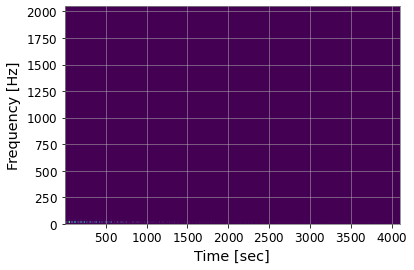

In [0]:
import scipy
f, t, Sxx = scipy.signal.spectrogram(signal, 4096)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

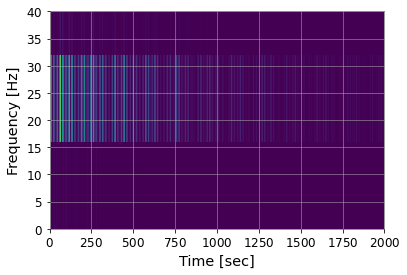

In [0]:
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlim(left=0,right=2000)
plt.ylim(bottom=0,top=40)
plt.xlabel('Time [sec]')
plt.show()

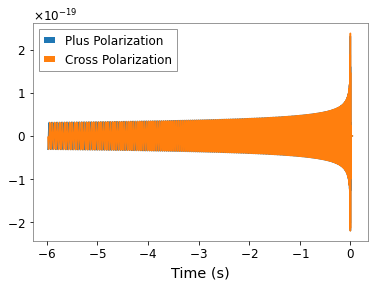

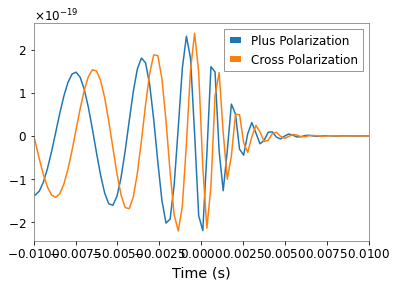

In [0]:
from pycbc.waveform import get_td_waveform
import pylab

# The output of this function are the "plus" and "cross" polarizations of the gravitational-wave signal 
# as viewed from the line of sight at a given source inclination (assumed face-on if not provided)
hp, hc = get_td_waveform(approximant='SEOBNRv4_opt',
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=20)

pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.grid()
pylab.show()

# Zoom in near the merger time#
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.xlim(-.01, .01)
pylab.legend()
pylab.grid()
pylab.show()

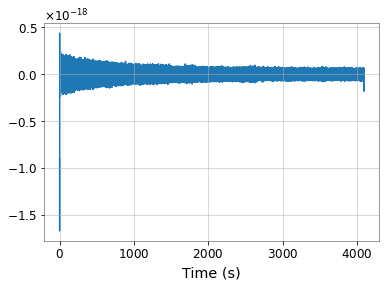

In [0]:
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.types import TimeSeries
gw_timeseries = TimeSeries(signal, delta_t=1/4096, epoch=0)


# Remove the low frequency content and downsample the data to 2048Hz
gw_timeseries = resample_to_delta_t(highpass(gw_timeseries, 15.0), 1.0/2048)

pylab.plot(gw_timeseries.sample_times, gw_timeseries)
pylab.xlabel('Time (s)')
pylab.show()

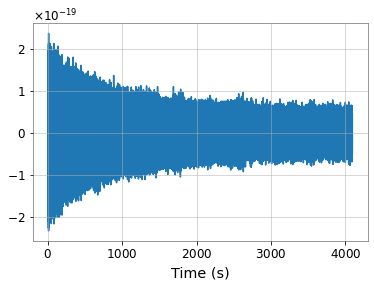

In [0]:
strain=gw_timeseries
conditioned = strain.crop(2, 2)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

In [0]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samles of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner

psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to informat the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, 4 * conditioned.sample_rate,
                                  low_frequency_cutoff=20)

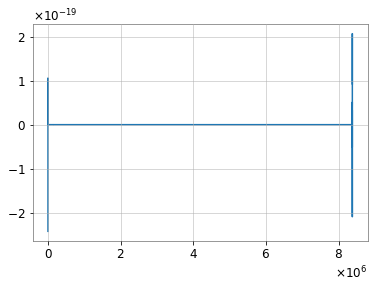

In [0]:


hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=10,
                     mass2=10,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# We will resize the vector to match our data
hp.resize(len(conditioned))

# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the 
# first bin of the data.

# This function rotates the vector by a fixed amount of time.
# It treats the data as if it were on a ring. Note that
# time stamps are *not* in general affected, but the true
# position in the vector is.
#
# By convention waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to 
# shift the merger into position
template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(template)
pylab.show()

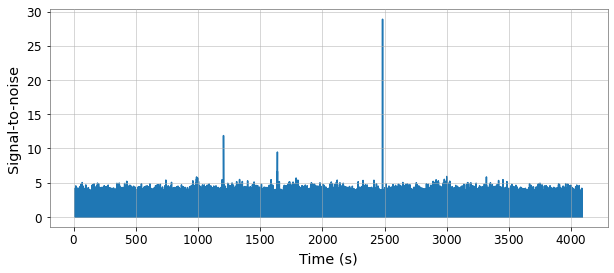

We found a signal at 2483.96728515625s with SNR 28.875743646459227


In [0]:

from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why am I taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [0]:

from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

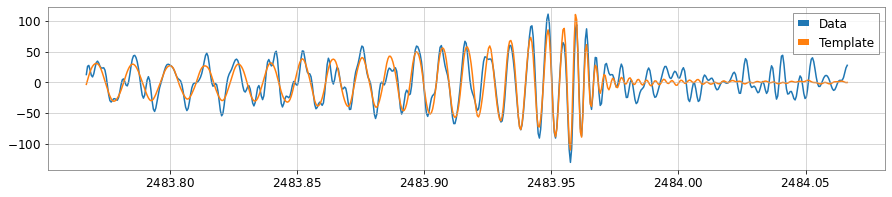

In [0]:
time=2483.96728515625
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(time-0.2, time+.10)
white_template = white_template.time_slice(time-0.2, time+.10)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

In [0]:
import tensorflow as tf

In [0]:
tf.keras.metrics.mean_absolute_error(white_data,white_template).numpy()


12.176302002655005